In [1]:
import tensorflow as tf
import pickle
from util import *
from load_data import load_input_file, build_combined_input
from NN_train import *
path_tosave = 'Models/V05_SvsS'
mkdir_p(path_tosave)
features_to_ignore = []
#features_to_ignore = ["DPhill_SS"]
features_to_ignore = ["DPhill_SS", "DeltaR_min_lep_bjet77", "DRll01","HT_jets","sumPsbtag","met_met","Mll01","DEtall_SS","jet_pseudoscore_DL1r2","nJets_OR_DL1r_77","sumPsbtag77"]

In [2]:
samples, feature_names, class_names, class_no = load_input_file('data/V05_SvsS.h5', features_to_ignore)

Ignoring feature:  DPhill_SS
Ignoring feature:  DeltaR_min_lep_bjet77
Ignoring feature:  DRll01
Ignoring feature:  HT_jets
Ignoring feature:  sumPsbtag
Ignoring feature:  met_met
Ignoring feature:  Mll01
Ignoring feature:  DEtall_SS
Ignoring feature:  jet_pseudoscore_DL1r2
Ignoring feature:  nJets_OR_DL1r_77
Ignoring feature:  sumPsbtag77
Found 23 features on the dataset 12 features were loaded: 

HT_lep
MtLepMet
jet_pseudoscore_DL1r0
jet_pseudoscore_DL1r1
DeltaR_max_lep_bjet77
DRjj_lead
jet_pt0_nofwd
total_charge
nJets_OR
randomRunNumber
weight_cuu_0p00_cqu1_0p10_cqu8_0p20
weight_cuu_0p04
 


In [3]:
targets = []
sample0, *other = samples
targets.extend( np.ones( sample0.data().shape[0] ) * sample0.class_label() )
inputs = sample0.data()
targets = np.array(targets, dtype = int )
weights = inputs[:,-1]
inputs = inputs[:,0:-1]
targets = targets[np.where((weights<1) &(weights>0))]
inputs  = inputs[np.where((weights<1) &(weights>0))]
weights = weights[np.where((weights<1) &(weights>0))]
data_len = inputs.shape[0]

In [4]:
weights_cuu = inputs[:,-1]
weights_cqu = inputs[:,-2]
weights_cuu_int = (inputs[:,-1] * 10).astype(int)
weights_cqu_int = (inputs[:,-2] * 10).astype(int)
Number_org = inputs[:,-3]
inputs = inputs[:,0:-3]
feature_names = feature_names[0:-3]
feature_names

['HT_lep',
 'MtLepMet',
 'jet_pseudoscore_DL1r0',
 'jet_pseudoscore_DL1r1',
 'DeltaR_max_lep_bjet77',
 'DRjj_lead',
 'jet_pt0_nofwd',
 'total_charge',
 'nJets_OR']

In [5]:
reweighted_inputs = np.zeros([weights_cuu_int.sum()+weights_cqu_int.sum(),inputs.shape[1]])
targets = np.concatenate([np.zeros(weights_cuu_int.sum()), np.ones(weights_cqu_int.sum())])
Numbers = np.zeros([weights_cuu_int.sum()+weights_cqu_int.sum()])
counter = 0
for i in range(weights_cuu_int.shape[0]):
    for j in range(weights_cuu_int[i]):
        reweighted_inputs[counter,:] = inputs[i,:]
        Numbers[counter] = Number_org[i]
        counter +=1
for i in range(weights_cqu_int.shape[0]):
    for j in range(weights_cqu_int[i]):
        reweighted_inputs[counter,:] = inputs[i,:]
        Numbers[counter] = Number_org[i]
        counter +=1        

In [6]:
scaler = StandardScaler().fit(reweighted_inputs)
input_scaled = scaler.transform(reweighted_inputs)

In [7]:
norw_input_scaled = scaler.transform(inputs)

for i in range(input_scaled.shape[1]):
    max_val = input_scaled[:,i].max()
    min_val = input_scaled[:,i].min()
    plt.title(str(feature_names[i]))
    cqu = plt.hist(input_scaled[targets==1], bins=40, range=(min_val, max_val), histtype='step', label='Cqu1+Cqu8', density=True)
    cuu = plt.hist(input_scaled[targets==0], bins=40, range=(min_val, max_val), histtype='step', label='Cuu', density=True)
    plt.hist(norw_input_scaled[:,i], bins=40, histtype='step', linestyle=('dashed'), weights = weights_cuu, density=True, label='Rw-hist Cuu')
    plt.hist(norw_input_scaled[:,i], bins=40, histtype='step', linestyle=('dashed'), weights = weights_cqu, density=True, label='Rw-hist Cqu1+Cqu8')
    plt.legend(frameon=False)
    save_name = path_tosave + "/Input_Feature_" + str(i) + ".png"
    plt.savefig(save_name)
    plt.show()
    if i==3:
        break

In [8]:
def Fold_Odd_Even_changed(input, targets, Number):
    input_odd = input[Number % 2 == 1]
    targets_odd = targets[Number % 2 == 1]
    input_even = input[Number % 2 == 0]
    targets_even = targets[Number % 2 == 0]
    return (input_odd, targets_odd), (input_even, targets_even)

In [9]:
odd, even = Fold_Odd_Even_changed(input_scaled, targets, Numbers)

In [10]:
def Train_Odd_Even_changed(odd, even, n_epochs = 400, batch_size = 2000):
    fit_history_list = []
    model_list = []
    input_shape = odd[0].shape[1]

    lr_schedule = tf.keras.callbacks.LearningRateScheduler(lr_step_decay)

    X_odd, X_val_odd, y_odd, y_val_odd, = train_test_split(odd[0], odd[1], test_size=0.2)
    X_even, X_val_even, y_even, y_val_even, = train_test_split(even[0], even[1], test_size=0.2)

    model_odd = Create_Model_basic(input_shape)
    model_even = Create_Model_basic(input_shape)
    fit_history_odd = model_odd.fit(X_odd, y_odd, epochs = n_epochs, shuffle = True, batch_size = batch_size, validation_data=(X_val_odd, y_val_odd), verbose=1 ,callbacks=[tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 100, verbose = True, min_delta = 0.001),lr_schedule]) #
    fit_history_even = model_even.fit(X_even, y_even, epochs = n_epochs, shuffle = True, batch_size = batch_size, validation_data=(X_val_even, y_val_even), verbose=1 ,callbacks=[tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 100, verbose = True, min_delta = 0.001),lr_schedule]) #

    return fit_history_odd, model_odd, fit_history_even, model_even

In [11]:
input_shape = odd[0].shape[1]
n_epochs = 50
batch_size = 20000

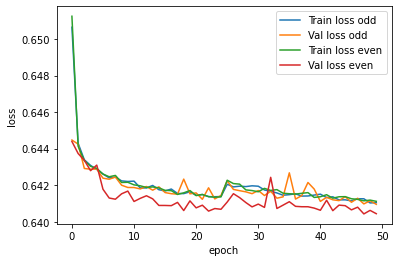

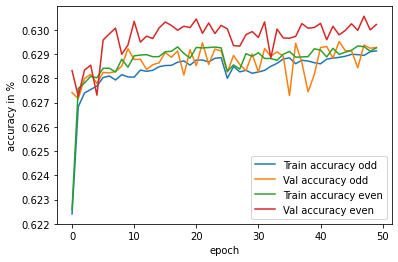

Saving architecture to: /mnt/c/Users/aaron/Desktop/PhD/Same_Sign_Top/NN_for_sstt/NN/Models/V05_SvsS/architecture_odd.json
Saving weights to     : /mnt/c/Users/aaron/Desktop/PhD/Same_Sign_Top/NN_for_sstt/NN/Models/V05_SvsS/weights_odd.h5
Saving architecture to: /mnt/c/Users/aaron/Desktop/PhD/Same_Sign_Top/NN_for_sstt/NN/Models/V05_SvsS/architecture_even.json
Saving weights to     : /mnt/c/Users/aaron/Desktop/PhD/Same_Sign_Top/NN_for_sstt/NN/Models/V05_SvsS/weights_even.h5


In [13]:
#history_odd, model_odd, history_even, model_even= Train_Odd_Even_changed(odd, even, n_epochs = n_epochs, batch_size = batch_size)

#history_list = [history_odd, history_even]
#Plot_Metrics_KFold(history_list, path_tosave)
#Save_Model(model_odd, path_tosave, "_odd")
#Save_Model(model_even, path_tosave, "_even")

In [14]:
model_odd = Load_Model(path_tosave, name="_odd")
model_even = Load_Model(path_tosave, name="_even")
pickle.dump(scaler, open(path_tosave + '/scaler.pkl','wb'))

Loading model architecture and weights (/mnt/c/Users/aaron/Desktop/PhD/Same_Sign_Top/NN_for_sstt/NN/Models/V05_SvsS/architecture_odd.json, /mnt/c/Users/aaron/Desktop/PhD/Same_Sign_Top/NN_for_sstt/NN/Models/V05_SvsS/weights_odd.h5)
Loading model architecture and weights (/mnt/c/Users/aaron/Desktop/PhD/Same_Sign_Top/NN_for_sstt/NN/Models/V05_SvsS/architecture_even.json, /mnt/c/Users/aaron/Desktop/PhD/Same_Sign_Top/NN_for_sstt/NN/Models/V05_SvsS/weights_even.h5)


In [15]:
def plot_roc_curve_SvS(model,data,path_tosave,odd=True):
    pred = model.predict(data[0])
    truth = data[1]
    fpr, tpr, thr = roc_curve(truth, pred)
    roc_auc = auc(fpr, tpr)

    fig = plt.figure()
    plt.plot(fpr, tpr, color='darkorange',
             label='ROC curve (area = {:.4f})'.format(roc_auc))
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc="lower right")
    if odd==True:
        plt.savefig(path_tosave+"/ROC_odd_model.png")
    else:
        plt.savefig(path_tosave+"/ROC_even_model.png")
    plt.show()

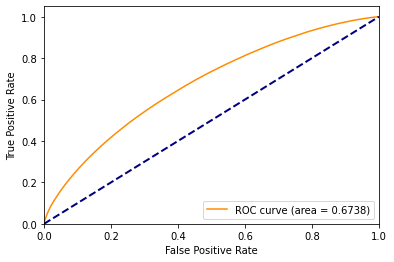

/home/avdgraaf/.local/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


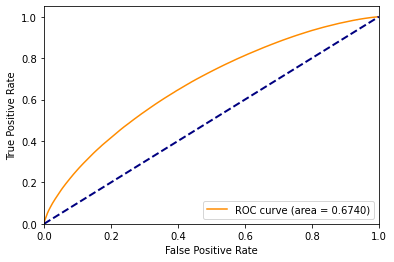

In [16]:
plot_roc_curve_SvS(model_even, odd, path_tosave, odd=False)
plot_roc_curve_SvS(model_odd, even, path_tosave, odd=True)

In [17]:
Predicted_even = model_odd.predict(even[0])
Predicted_odd = model_even.predict(odd[0])

In [18]:
Predicted_Combined = np.squeeze(np.concatenate([Predicted_even, Predicted_odd]))
targets_Combined = np.concatenate([even[1], odd[1]])

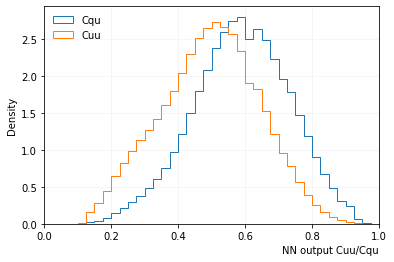

In [19]:
fig = plt.figure()
plt.grid(color='k', which='both', linestyle='--', lw=0.5, alpha=0.1, zorder = 0)
plt.xlabel("NN output Cuu/Cqu", horizontalalignment='right', x=1)
plt.xlim([0,1])
plt.ylabel("Density")
histargs = {"bins":40, "range":(0,1.), "density":True, "histtype":'step'}
plt.hist(Predicted_Combined[targets_Combined==1],label = "Cqu", **histargs)
plt.hist(Predicted_Combined[targets_Combined==0],label = "Cuu", **histargs)
plt.legend(loc='upper left', frameon=False,)
saveit = "{}/{}".format(path_tosave, "DNN_Output.png")
plt.savefig(saveit)

# Testing with not really reweighted Data

In [20]:
samples, feature_names, class_names, class_no = load_input_file('data/V05_SvsS.h5', features_to_ignore)
targets = []

sample0, *other = samples
targets.extend( np.ones( sample0.data().shape[0] ) * sample0.class_label() )
inputs = sample0.data()
targets = np.array(targets, dtype = int )
weights = inputs[:,-1]
inputs = inputs[:,0:-1]
targets = targets[np.where((weights<1) &(weights>0))]
inputs  = inputs[np.where((weights<1) &(weights>0))]
weights = weights[np.where((weights<1) &(weights>0))]
data_len = inputs.shape[0]

weights_cuu = inputs[:,-1]
weights_cqu = inputs[:,-2]
weights_cuu_int = (inputs[:,-1] * 10).astype(int)
weights_cqu_int = (inputs[:,-2] * 10).astype(int)
Number_org = inputs[:,-3]
inputs = inputs[:,0:-3]
feature_names = feature_names[0:-3]
feature_names

Ignoring feature:  DPhill_SS
Ignoring feature:  DeltaR_min_lep_bjet77
Ignoring feature:  DRll01
Ignoring feature:  HT_jets
Ignoring feature:  sumPsbtag
Ignoring feature:  met_met
Ignoring feature:  Mll01
Ignoring feature:  DEtall_SS
Ignoring feature:  jet_pseudoscore_DL1r2
Ignoring feature:  nJets_OR_DL1r_77
Ignoring feature:  sumPsbtag77
Found 23 features on the dataset 12 features were loaded: 

HT_lep
MtLepMet
jet_pseudoscore_DL1r0
jet_pseudoscore_DL1r1
DeltaR_max_lep_bjet77
DRjj_lead
jet_pt0_nofwd
total_charge
nJets_OR
randomRunNumber
weight_cuu_0p00_cqu1_0p10_cqu8_0p20
weight_cuu_0p04
 


['HT_lep',
 'MtLepMet',
 'jet_pseudoscore_DL1r0',
 'jet_pseudoscore_DL1r1',
 'DeltaR_max_lep_bjet77',
 'DRjj_lead',
 'jet_pt0_nofwd',
 'total_charge',
 'nJets_OR']

In [21]:
inputs_test = scaler.transform(inputs)

In [22]:
Predictions_even = model_odd.predict(inputs_test[Number_org % 2 == 0])
Predictions_odd = model_even.predict(inputs_test[Number_org % 2 == 1])
targets_even = targets[Number_org % 2 == 0]
targets_odd = targets[Number_org % 2 == 1]
weights_cuu_even = weights_cuu[Number_org % 2 == 0]
weights_cuu_odd = weights_cuu[Number_org % 2 == 1]
weights_cqu_even = weights_cqu[Number_org % 2 == 0]
weights_cqu_odd = weights_cqu[Number_org % 2 == 1]

Predictions = np.concatenate([Predictions_even,Predictions_odd])
targets = np.concatenate([targets_even, targets_odd])
weights_cuu = np.concatenate([weights_cuu_even, weights_cuu_odd])
weights_cqu = np.concatenate([weights_cqu_even, weights_cqu_odd])

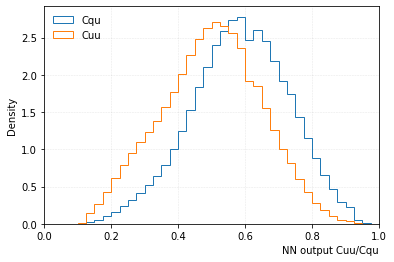

In [23]:
fig = plt.figure()
plt.grid(color='k', which='both', linestyle='--', lw=0.5, alpha=0.1, zorder = 0)
plt.xlabel("NN output Cuu/Cqu", horizontalalignment='right', x=1)
plt.xlim([0,1])
plt.ylabel("Density")
histargs = {"bins":40, "range":(0,1.), "density":True, "histtype":'step'}
plt.hist(Predictions, label = "Cqu", **histargs, weights=weights_cqu)
plt.hist(Predictions, label = "Cuu", **histargs, weights=weights_cuu)
plt.legend(frameon=False, loc='upper left')
plt.savefig("DNN_Output.png")
plt.show()

# Test on Background

In [24]:
samples, feature_names, class_names, class_no = load_input_file('data/V05_sstt_Data.h5', features_to_ignore)
input_features, targets, class_labels, weights = build_combined_input(samples)

Ignoring feature:  DPhill_SS
Ignoring feature:  DeltaR_min_lep_bjet77
Ignoring feature:  DRll01
Ignoring feature:  HT_jets
Ignoring feature:  sumPsbtag
Ignoring feature:  met_met
Ignoring feature:  Mll01
Ignoring feature:  DEtall_SS
Ignoring feature:  jet_pseudoscore_DL1r2
Ignoring feature:  nJets_OR_DL1r_77
Ignoring feature:  sumPsbtag77
Found 21 features on the dataset 10 features were loaded: 

HT_lep
MtLepMet
jet_pseudoscore_DL1r0
jet_pseudoscore_DL1r1
DeltaR_max_lep_bjet77
DRjj_lead
jet_pt0_nofwd
total_charge
nJets_OR
randomRunNumber
 
Dataset contains extra labels for different backgrounds!
Class 0  :  253953
Class 1  :  231587
Class 2  :  3249
Class 3  :  310859
Class 4  :  190589
Class 5  :  223033
Class 6  :  355647
Class 7  :  109991
Class 8  :  1039
Class 9  :  0
Class 10  :  425286
Dataset contains 679239 Signal events and 1425994 Background events.


In [25]:
feature_names

['HT_lep',
 'MtLepMet',
 'jet_pseudoscore_DL1r0',
 'jet_pseudoscore_DL1r1',
 'DeltaR_max_lep_bjet77',
 'DRjj_lead',
 'jet_pt0_nofwd',
 'total_charge',
 'nJets_OR',
 'randomRunNumber']

In [26]:
feature_names = feature_names[:-1]
run_numbers = input_features[:,9]
input_features = input_features[:,0:9]

In [27]:
background_events = input_features[targets==0]
background_run_numbers = run_numbers[targets==0]
background_weights = weights[targets==0]
background_class_labels = class_labels[targets==0]
background_events = scaler.transform(background_events)
odd_background, even_background = Fold_Odd_Even(background_events, targets[targets==0], background_weights, background_class_labels, background_run_numbers)

In [28]:
signal_events = input_features[targets==1]
signal_run_numbers = run_numbers[targets==1]
signal_weights = weights[targets==1]
signal_class_labels = class_labels[targets==1]
signal_events = scaler.transform(signal_events)
odd_signal, even_signal = Fold_Odd_Even(signal_events, targets[targets==1], signal_weights, signal_class_labels, signal_run_numbers)

In [29]:
Predict_bkg_odd = model_even.predict(odd_background[0])
Predict_bkg_even = model_odd.predict(even_background[0])
Predict_sig_odd = model_even.predict(odd_signal[0])
Predict_sig_even = model_odd.predict(even_signal[0])

Background_class_labels = np.concatenate([odd_background[3], even_background[3]])
Predicted_Background = np.concatenate([Predict_bkg_odd, Predict_bkg_even])
Predicted_Signal = np.concatenate([Predict_sig_odd, Predict_sig_even])

In [30]:
def Find_Eff_Cut_Equal(Sig, Bkg):
    steps = 1000
    Cut = np.linspace(0,1,steps)
    Sig_Eff_list = []
    Bkg_Eff_list = []
    for i in range(steps):    
        Sig_Eff_list.append(Sig[Sig > Cut[i]].size/Sig.size)
        Bkg_Eff_list.append(Bkg[Bkg < Cut[i]].size/Bkg.size)
    Sig_Eff_list = np.array(Sig_Eff_list)
    Bkg_Eff_list = np.array(Bkg_Eff_list)
    best_step = np.argmax(Sig_Eff_list + Bkg_Eff_list)
    
    print(f"Cut_Value: {Cut[best_step]:.3f}")
    print(f"Sig_Eff: {Sig_Eff_list[best_step]:.3f}")
    print(f"Bkg_Eff: {Bkg_Eff_list[best_step]:.3f}")
    
    return Sig_Eff_list[best_step], Bkg_Eff_list[best_step], Cut[best_step]

Sig = Predicted_Combined[targets_Combined==1]
Bkg = Predicted_Combined[targets_Combined==0]
Sig_Eff, Bkg_Eff, Signal_Cut = Find_Eff_Cut_Equal(Sig=Sig, Bkg=Bkg)

Cut_Value: 0.543
Sig_Eff: 0.631
Bkg_Eff: 0.615


ValueError: weights should have the same shape as x

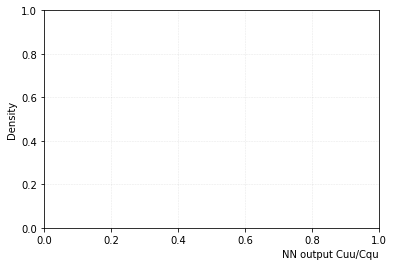

In [219]:
fig = plt.figure()
plt.grid(color='k', which='both', linestyle='--', lw=0.5, alpha=0.1, zorder = 0)
plt.xlabel("NN output Cuu/Cqu", horizontalalignment='right', x=1)
plt.xlim([0,1])
plt.ylabel("Density")
histargs = {"bins":40, "range":(0,1.), "density":True, "histtype":'step'}
#plt.hist(Predicted_Background, label = "Background", **histargs)
#plt.hist(Predicted_Signal, label="Signal", **histargs)
plt.hist(Predictions, label = "Cqu Signal", **histargs, weights=weights_cqu)
plt.hist(Predictions, label = "Cuu Signal", **histargs, weights=weights_cuu)
plt.vlines(Signal_Cut, ymin=plt.gca().get_ylim()[0]+ plt.gca().get_ylim()[1]*0.02, ymax=plt.gca().get_ylim()[1]*0.98, color='red', linestyle='--', label='Cut-Value', alpha=0.8, linewidth=1.3)

plt.legend(frameon=False, loc='upper left')
plt.show()

In [32]:
index_sort = np.argsort(class_no)
class_names = (np.array(class_names)[index_sort])
class_no = np.sort(class_no)

In [33]:
background_weights = np.concatenate([odd_background[2], even_background[2]])

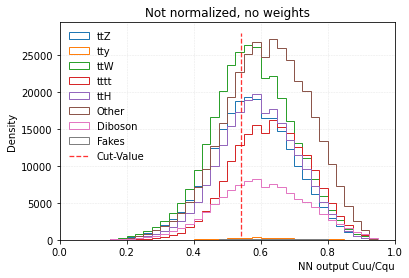

In [34]:
fig = plt.figure()
plt.grid(color='k', which='both', linestyle='--', lw=0.5, alpha=0.1, zorder = 0)
plt.xlabel("NN output Cuu/Cqu", horizontalalignment='right', x=1)
plt.xlim([0,1])
plt.ylabel("Density")
histargs = {"bins":40, "range":(0,1.), "histtype":'step'}
for i in range(1,9):
    plt.hist(Predicted_Background[Background_class_labels == i], label = class_names[i], **histargs)
plt.vlines(Signal_Cut, ymin=plt.gca().get_ylim()[0]+ plt.gca().get_ylim()[1]*0.02, ymax=plt.gca().get_ylim()[1]*0.98, color='red', linestyle='--', label='Cut-Value', alpha=0.8, linewidth=1.3)
plt.title("Not normalized, no weights")
plt.legend(frameon=False, loc='upper left')
plt.show()

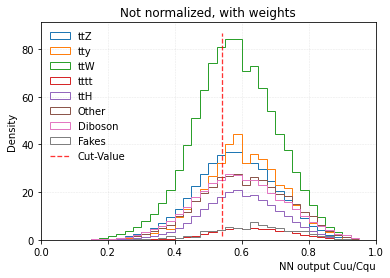

In [35]:
fig = plt.figure()
plt.grid(color='k', which='both', linestyle='--', lw=0.5, alpha=0.1, zorder = 0)
plt.xlabel("NN output Cuu/Cqu", horizontalalignment='right', x=1)
plt.xlim([0,1])
plt.ylabel("Density")
histargs = {"bins":40, "range":(0,1.), "histtype":'step'}
for i in range(1,9):
    plt.hist(Predicted_Background[Background_class_labels == i], label = class_names[i], **histargs, weights=background_weights[Background_class_labels == i])
plt.vlines(Signal_Cut, ymin=plt.gca().get_ylim()[0]+ plt.gca().get_ylim()[1]*0.02, ymax=plt.gca().get_ylim()[1]*0.98, color='red', linestyle='--', label='Cut-Value', alpha=0.8, linewidth=1.3)
plt.title("Not normalized, with weights")
plt.legend(frameon=False, loc='upper left')
plt.show()

# Feature Importance

f, g = get_feature_importance(odd, model_even, Signal_Cut, 2)
idx = np.argsort(f)
fig, ax = plt.subplots(figsize=(20, 10))
ax.barh(range(odd[0].shape[1]), np.sort(f), color="r", alpha=0.7)
ax.set_yticks(range(odd[0].shape[1]), np.array(feature_names)[idx])
ax.set_xlabel('Feature Importance')
plt.savefig(path_tosave + "/Feature_Importance.png")

# Split into Cuu SR & Cqu SR

In [36]:
def Split_in_SR(input_data, Predict, Signal_Cut):
    mask_cuu = np.squeeze(Predict < Signal_Cut)
    mask_cqu = np.squeeze(Predict >= Signal_Cut)
    features_cuu = input_data[0][mask_cuu,:]
    features_cqu = input_data[0][mask_cqu,:]
    targets_cuu = input_data[1][mask_cuu]
    targets_cqu = input_data[1][mask_cqu]
    weights_cuu = input_data[2][mask_cuu]
    weights_cqu = input_data[2][mask_cqu]
    class_labels_cuu = input_data[3][mask_cuu]
    class_labels_cqu = input_data[3][mask_cqu]
    cuu = (features_cuu, targets_cuu, weights_cuu, class_labels_cuu)
    cqu = (features_cqu, targets_cqu, weights_cqu, class_labels_cqu)
    return cuu, cqu

In [37]:
odd_background_cuu, odd_background_cqu = Split_in_SR(odd_background, Predict_bkg_odd, Signal_Cut=Signal_Cut)
even_background_cuu, even_background_cqu = Split_in_SR(even_background, Predict_bkg_even, Signal_Cut=Signal_Cut)
odd_signal_cuu, odd_signal_cqu = Split_in_SR(odd_signal, Predict_sig_odd, Signal_Cut=Signal_Cut)
even_signal_cuu, even_signal_cqu = Split_in_SR(even_signal, Predict_sig_even, Signal_Cut=Signal_Cut)

In [38]:
def Combine_Signal_Background(Sig, Bkg):
    a0 = np.concatenate([Sig[0],Bkg[0]])
    a1 = np.concatenate([Sig[1],Bkg[1]])
    a2 = np.concatenate([Sig[2],Bkg[2]])
    a3 = np.concatenate([Sig[3],Bkg[3]])
    return (a0, a1, a2, a3)

In [39]:
odd_cuu = Combine_Signal_Background(odd_signal_cuu, odd_background_cuu)
even_cuu = Combine_Signal_Background(even_signal_cuu, even_background_cuu)
odd_cqu = Combine_Signal_Background(odd_signal_cqu, odd_background_cqu)
even_cqu = Combine_Signal_Background(even_signal_cqu, even_background_cqu)

In [40]:
ScaleWeights(odd_cuu[1],odd_cuu[2])
ScaleWeights(even_cuu[1],even_cuu[2])
ScaleWeights(odd_cqu[1],odd_cqu[2])
ScaleWeights(even_cqu[1],even_cqu[2])


======Weight Statistic========================================
Weights::        W(1)=253.997, W(0)=540.527
Scaled weights:: W(1)=212539, W(0)=212539

======Weight Statistic========================================
Weights::        W(1)=248.496, W(0)=491.312
Scaled weights:: W(1)=192972, W(0)=192971

======Weight Statistic========================================
Weights::        W(1)=352.163, W(0)=960.52
Scaled weights:: W(1)=323239, W(0)=323239

======Weight Statistic========================================
Weights::        W(1)=345.822, W(0)=991.329
Scaled weights:: W(1)=323867, W(0)=323866


# Train SvsB NN

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 9)]               0         
_________________________________________________________________
dense_10 (Dense)             (None, 128)               1280      
_________________________________________________________________
dense_11 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_12 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_13 (Dense)             (None, 16)                528       
_________________________________________________________________
dense_14 (Dense)             (None, 8)                 136       
_________________________________________________________________
OutputLayer (Dense)          (None, 1)                 9   

/home/avdgraaf/.local/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


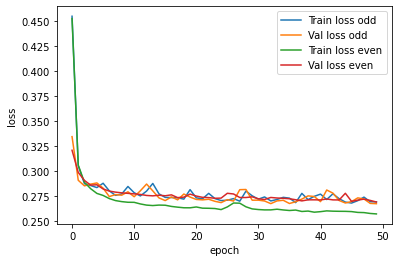

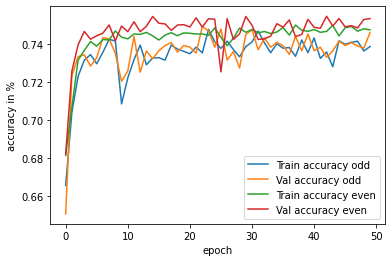

In [41]:
#hist_cuu_odd, model_cuu_odd, hist_cuu_even, model_cuu_even = Train_Odd_Even(odd_cuu, even_cuu, n_epochs = n_epochs, batch_size = batch_size)
#history_list_cuu = [hist_cuu_odd, hist_cuu_even]
#Plot_Metrics_KFold(history_list_cuu, path_tosave)

#Save_Model(model_cuu_odd, path_tosave, "_odd_cuu")
#Save_Model(model_cuu_even, path_tosave, "_even_cuu")

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 9)]               0         
_________________________________________________________________
dense_20 (Dense)             (None, 128)               1280      
_________________________________________________________________
dense_21 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_22 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_23 (Dense)             (None, 16)                528       
_________________________________________________________________
dense_24 (Dense)             (None, 8)                 136       
_________________________________________________________________
OutputLayer (Dense)          (None, 1)                 9   

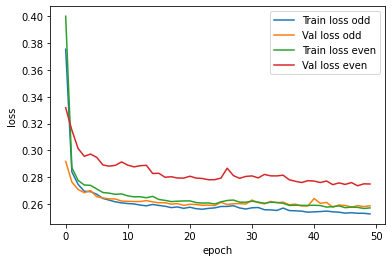

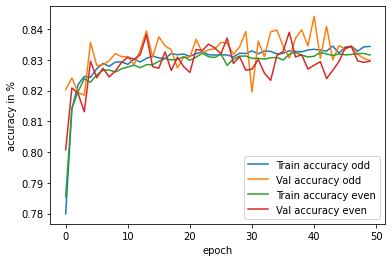

In [43]:
#hist_cqu_odd, model_cqu_odd, hist_cqu_even, model_cqu_even = Train_Odd_Even(odd_cqu, even_cqu, n_epochs = n_epochs, batch_size = batch_size)
#history_list_cqu = [hist_cqu_odd, hist_cqu_even]
#Plot_Metrics_KFold(history_list_cqu, path_tosave)

#Save_Model(model_cqu_odd, path_tosave, "_odd_cqu")
#Save_Model(model_cqu_even, path_tosave, "_even_cqu")

In [45]:
model_cuu_even = Load_Model(path_tosave, name="_even_cuu")
model_cuu_odd = Load_Model(path_tosave, name="_odd_cuu")
model_cqu_even = Load_Model(path_tosave, name="_even_cqu")
model_cqu_odd = Load_Model(path_tosave, name="_odd_cqu")

Loading model architecture and weights (/mnt/c/Users/aaron/Desktop/PhD/Same_Sign_Top/NN_for_sstt/NN/Models/V05_SvsS/architecture_even_cuu.json, /mnt/c/Users/aaron/Desktop/PhD/Same_Sign_Top/NN_for_sstt/NN/Models/V05_SvsS/weights_even_cuu.h5)
Loading model architecture and weights (/mnt/c/Users/aaron/Desktop/PhD/Same_Sign_Top/NN_for_sstt/NN/Models/V05_SvsS/architecture_odd_cuu.json, /mnt/c/Users/aaron/Desktop/PhD/Same_Sign_Top/NN_for_sstt/NN/Models/V05_SvsS/weights_odd_cuu.h5)
Loading model architecture and weights (/mnt/c/Users/aaron/Desktop/PhD/Same_Sign_Top/NN_for_sstt/NN/Models/V05_SvsS/architecture_even_cqu.json, /mnt/c/Users/aaron/Desktop/PhD/Same_Sign_Top/NN_for_sstt/NN/Models/V05_SvsS/weights_even_cqu.h5)
Loading model architecture and weights (/mnt/c/Users/aaron/Desktop/PhD/Same_Sign_Top/NN_for_sstt/NN/Models/V05_SvsS/architecture_odd_cqu.json, /mnt/c/Users/aaron/Desktop/PhD/Same_Sign_Top/NN_for_sstt/NN/Models/V05_SvsS/weights_odd_cqu.h5)


In [190]:
# Reload data to reset weights
odd_cuu = Combine_Signal_Background(odd_signal_cuu, odd_background_cuu)
even_cuu = Combine_Signal_Background(even_signal_cuu, even_background_cuu)
odd_cqu = Combine_Signal_Background(odd_signal_cqu, odd_background_cqu)
even_cqu = Combine_Signal_Background(even_signal_cqu, even_background_cqu)

In [191]:
pred1 = model_cuu_odd.predict(even_cuu[0])
pred2 = model_cuu_even.predict(odd_cuu[0])
pred3 = model_cqu_odd.predict(even_cqu[0])
pred4 = model_cqu_even.predict(odd_cqu[0])

truth1 = even_cuu[1]
truth2 = odd_cuu[1]
truth3 = even_cqu[1]
truth4 = odd_cqu[1]

weights1 = even_cuu[2]
weights2 = odd_cuu[2]
weights3 = even_cqu[2]
weights4 = odd_cqu[2]

class1 = even_cuu[3]
class2 = odd_cuu[3]
class3 = even_cqu[3]
class4 = odd_cqu[3]

pred = np.concatenate([pred1, pred2, pred3, pred4])
truth = np.concatenate([truth1, truth2, truth3, truth4])
weights = np.concatenate([weights1, weights2, weights3, weights4])

pred_cuu = np.concatenate([pred1, pred2])
truth_cuu = np.concatenate([truth1, truth2])
weights_cuu = np.concatenate([weights1, weights2])
class_cuu = np.concatenate([class1, class2])

pred_cqu = np.concatenate([pred3, pred4])
truth_cqu = np.concatenate([truth3, truth4])
weights_cqu = np.concatenate([weights3, weights4])
class_cqu = np.concatenate([class3, class4])

In [179]:
charge_cuu = np.concatenate([even_cuu[0][:,7], odd_cuu[0][:,7]])
charge_cqu = np.concatenate([even_cqu[0][:,7], odd_cqu[0][:,7]])

In [196]:
pred_cuu_neg = pred_cuu[:,0][charge_cuu > 0]
truth_cuu_neg = truth_cuu[charge_cuu > 0]
weights_cuu_neg = weights_cuu[charge_cuu > 0]
class_cuu_neg = class_cuu[charge_cuu > 0]
pred_cuu_pos = pred_cuu[:,0][charge_cuu < 0]
truth_cuu_pos = truth_cuu[charge_cuu < 0]
weights_cuu_pos = weights_cuu[charge_cuu < 0]
class_cuu_pos = class_cuu[charge_cuu < 0]

In [197]:
pred_cqu_neg = pred_cqu[:,0][charge_cqu > 0]
truth_cqu_neg = truth_cqu[charge_cqu > 0]
weights_cqu_neg = weights_cqu[charge_cqu > 0]
class_cqu_neg = class_cqu[charge_cqu > 0]
pred_cqu_pos = pred_cqu[:,0][charge_cqu < 0]
truth_cqu_pos = truth_cqu[charge_cqu < 0]
weights_cqu_pos = weights_cqu[charge_cqu < 0]
class_cqu_pos = class_cqu[charge_cqu < 0]

In [217]:
weights_cqu_neg[truth_cqu_neg == 0].sum()

716.0464253213828

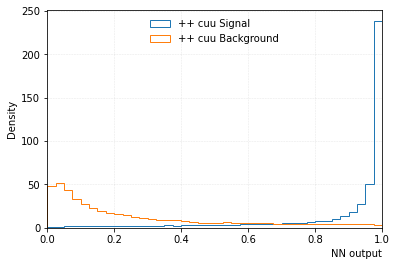

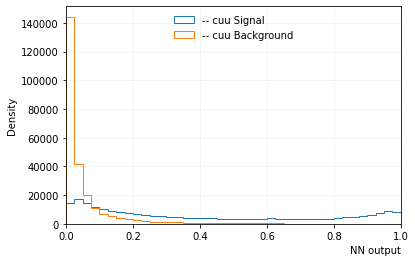

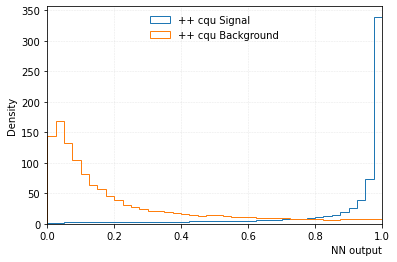

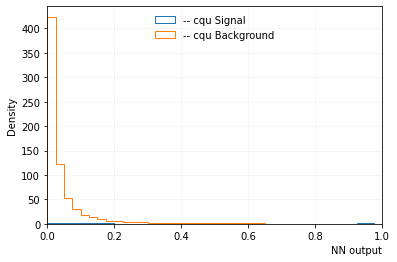

In [220]:
fig = plt.figure()
plt.grid(color='k', which='both', linestyle='--', lw=0.5, alpha=0.1, zorder = 0)
plt.xlabel("NN output", horizontalalignment='right', x=1)
plt.xlim([0,1])
plt.ylabel("Density")
#plt.yscale('log')
histargs = {"bins":40, "range":(0,1.), "histtype":'step'}
plt.hist(pred_cuu_pos[truth_cuu_pos==1],label = "++ cuu Signal", **histargs, weights=weights_cuu_pos[truth_cuu_pos==1])
plt.hist(pred_cuu_pos[truth_cuu_pos==0],label = "++ cuu Background", **histargs, weights=weights_cuu_pos[truth_cuu_pos==0])
plt.legend(loc='upper center', frameon=False)
plt.show()

fig = plt.figure()
plt.grid(color='k', which='both', linestyle='--', lw=0.5, alpha=0.1, zorder = 0)
plt.xlabel("NN output", horizontalalignment='right', x=1)
plt.xlim([0,1])
plt.ylabel("Density")
#plt.yscale('log')
histargs = {"bins":40, "range":(0,1.), "histtype":'step'}
plt.hist(pred_cuu_neg[truth_cuu_neg==1],label = "-- cuu Signal", **histargs)
plt.hist(pred_cuu_neg[truth_cuu_neg==0],label = "-- cuu Background", **histargs)
#plt.hist(pred_cuu_neg[truth_cuu_neg==1],label = "-- cuu Signal", **histargs, weights=weights_cuu_neg[truth_cuu_neg==1])
#plt.hist(pred_cuu_neg[truth_cuu_neg==0],label = "-- cuu Background", **histargs, weights=weights_cuu_neg[truth_cuu_neg==0])
plt.legend(loc='upper center', frameon=False)
plt.show()

fig = plt.figure()
plt.grid(color='k', which='both', linestyle='--', lw=0.5, alpha=0.1, zorder = 0)
plt.xlabel("NN output", horizontalalignment='right', x=1)
plt.xlim([0,1])
plt.ylabel("Density")
#plt.yscale('log')
histargs = {"bins":40, "range":(0,1.), "histtype":'step'}
plt.hist(pred_cqu_pos[truth_cqu_pos==1],label = "++ cqu Signal", **histargs, weights=weights_cqu_pos[truth_cqu_pos==1])
plt.hist(pred_cqu_pos[truth_cqu_pos==0],label = "++ cqu Background", **histargs, weights=weights_cqu_pos[truth_cqu_pos==0])
plt.legend(loc='upper center', frameon=False)
plt.show()

fig = plt.figure()
plt.grid(color='k', which='both', linestyle='--', lw=0.5, alpha=0.1, zorder = 0)
plt.xlabel("NN output", horizontalalignment='right', x=1)
plt.xlim([0,1])
plt.ylabel("Density")
#plt.yscale('log')
histargs = {"bins":40, "range":(0,1.), "histtype":'step'}
plt.hist(pred_cqu_neg[truth_cqu_neg==1],label = "-- cqu Signal", **histargs, weights=weights_cqu_neg[truth_cqu_neg==1])
plt.hist(pred_cqu_neg[truth_cqu_neg==0],label = "-- cqu Background", **histargs, weights=weights_cqu_neg[truth_cqu_neg==0])
plt.legend(loc='upper center', frameon=False)
plt.show()

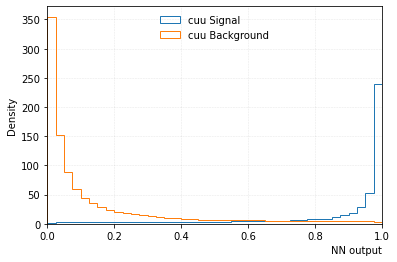

In [200]:
fig = plt.figure()
plt.grid(color='k', which='both', linestyle='--', lw=0.5, alpha=0.1, zorder = 0)
plt.xlabel("NN output", horizontalalignment='right', x=1)
plt.xlim([0,1])
plt.ylabel("Density")
#plt.yscale('log')
histargs = {"bins":40, "range":(0,1.), "histtype":'step'}
plt.hist(pred_cuu[:,0][truth_cuu==1],label = "cuu Signal", **histargs, weights=weights_cuu[truth_cuu==1])
plt.hist(pred_cuu[:,0][truth_cuu==0],label = "cuu Background", **histargs, weights=weights_cuu[truth_cuu==0])
plt.legend(loc='upper center', frameon=False)
plt.show()

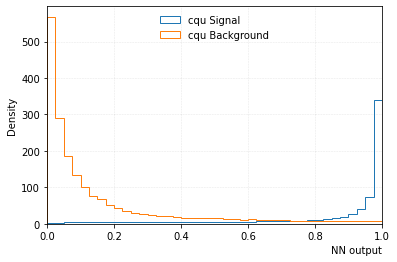

In [201]:
fig = plt.figure()
plt.grid(color='k', which='both', linestyle='--', lw=0.5, alpha=0.1, zorder = 0)
plt.xlabel("NN output", horizontalalignment='right', x=1)
plt.xlim([0,1])
plt.ylabel("Density")
#plt.yscale('log')
histargs = {"bins":40, "range":(0,1.), "histtype":'step'}
plt.hist(pred_cqu[:,0][truth_cqu==1],label = "cqu Signal", **histargs, weights=weights_cqu[truth_cqu==1])
plt.hist(pred_cqu[:,0][truth_cqu==0],label = "cqu Background", **histargs, weights=weights_cqu[truth_cqu==0])
plt.legend(loc='upper center', frameon=False)
plt.show()

In [202]:
fpr1, tpr1, thr1 = roc_curve(truth_cuu, pred_cuu, sample_weight=weights_cuu)
fpr2, tpr2, thr2 = roc_curve(truth_cqu, pred_cqu, sample_weight=weights_cqu)

roc_auc1 = auc(fpr1, tpr1)
roc_auc2 = auc(fpr2, tpr2)

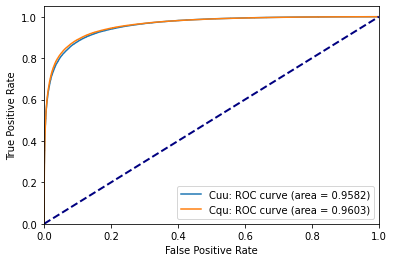

In [203]:
plt.plot(fpr1, tpr1 ,label='Cuu: ROC curve (area = {:.4f})'.format(roc_auc1))
plt.plot(fpr2, tpr2 ,label='Cqu: ROC curve (area = {:.4f})'.format(roc_auc2))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

# SvB NN with charge split

In [82]:
odd_cuu = Combine_Signal_Background(odd_signal_cuu, odd_background_cuu)
even_cuu = Combine_Signal_Background(even_signal_cuu, even_background_cuu)
odd_cqu = Combine_Signal_Background(odd_signal_cqu, odd_background_cqu)
even_cqu = Combine_Signal_Background(even_signal_cqu, even_background_cqu)

In [150]:
def Check_S_over_B(data_pos, data_neg):
    print("S/B for ++ =", np.round(data_pos[2][data_pos[1] == 1].sum() / data_pos[2][data_pos[1] == 0].sum()* 100, 1), "%")
    print("S/B for -- =", np.round(data_neg[2][data_neg[1] == 1].sum() / data_neg[2][data_neg[1] == 0].sum()* 100, 1), "%")

def Split_by_Charge(data, training=True):
    total_charge = data[0][:,7]
    input_data = np.delete(data[0], 7, 1)
    
    # IMPORTANT NOTE: total_charge is flipped due to the standard scaler which is scaling 2|254(negativ charge) 
    
    input_pos = input_data[total_charge < 0]
    targets_pos = data[1][total_charge < 0]
    weights_pos = data[2][total_charge < 0]
    class_labels_pos = data[3][total_charge < 0]

    input_neg = input_data[total_charge > 0]
    targets_neg = data[1][total_charge > 0]
    weights_neg = data[2][total_charge > 0]
    class_labels_neg = data[3][total_charge > 0]
    
    pos_tuple = (input_pos, targets_pos, weights_pos, class_labels_pos)
    neg_tuple = (input_neg, targets_neg, weights_neg, class_labels_neg)
    
    pos_frac = np.round(100 * input_pos.shape[0] / (input_pos.shape[0] + input_neg.shape[0]), 1)
    neg_frac = np.round(100 * input_neg.shape[0] / (input_pos.shape[0] + input_neg.shape[0]), 1)
    
    pos_weighted_frac = np.round(100 * weights_pos.sum() / (weights_pos.sum() + weights_neg.sum()), 1)
    neg_weighted_frac = np.round(100 * weights_neg.sum() / (weights_pos.sum() + weights_neg.sum()), 1)
    
    if training == True:
        print("Charge split fraction (++|--) event based is", pos_frac, "% |", neg_frac, "%, while weighted based it is", pos_weighted_frac, "% |", neg_weighted_frac, "% !")
        
        Check_S_over_B(pos_tuple, neg_tuple)
        
        ScaleWeights(targets_pos,weights_pos)
        ScaleWeights(targets_neg,weights_neg)
    
        print("\n Finished Data! \n")
    
    return pos_tuple, neg_tuple

In [151]:
#feature_names.remove('total_charge')
odd_cuu_pos, odd_cuu_neg = Split_by_Charge(odd_cuu)
even_cuu_pos, even_cuu_neg = Split_by_Charge(even_cuu)
odd_cqu_pos, odd_cqu_neg = Split_by_Charge(odd_cqu)
even_cqu_pos, even_cqu_neg = Split_by_Charge(even_cqu)

Charge split fraction (++|--) event based is 39.5 % | 60.5 %, while weighted based it is 61.8 % | 38.2 % !
S/B for ++ = 95.7 %
S/B for -- = 4.8 %

======Weight Statistic========================================
Weights::        W(1)=240.08, W(0)=250.739
Scaled weights:: W(1)=83908, W(0)=83908

======Weight Statistic========================================
Weights::        W(1)=13.9162, W(0)=289.788
Scaled weights:: W(1)=128631, W(0)=128631

 Finished Data! 

Charge split fraction (++|--) event based is 39.1 % | 60.9 %, while weighted based it is 62.0 % | 38.0 % !
S/B for ++ = 105.5 %
S/B for -- = 4.8 %

======Weight Statistic========================================
Weights::        W(1)=235.582, W(0)=223.206
Scaled weights:: W(1)=75389.5, W(0)=75389.5

======Weight Statistic========================================
Weights::        W(1)=12.9132, W(0)=268.106
Scaled weights:: W(1)=117582, W(0)=117582

 Finished Data! 

Charge split fraction (++|--) event based is 58.3 % | 41.7 %, while we

In [152]:
#hist_odd_cuu_pos, model_odd_cuu_pos, hist_even_cuu_pos, model_even_cuu_pos = Train_Odd_Even(odd_cuu_pos, even_cuu_pos, n_epochs = n_epochs, batch_size = batch_size)
#history_list_cuu_pos = [hist_odd_cuu_pos, hist_even_cuu_pos]
#Save_Model(model_odd_cuu_pos, path_tosave, "_odd_cuu_pos")
#Save_Model(model_even_cuu_pos, path_tosave, "_even_cuu_pos")
#hist_odd_cuu_neg, model_odd_cuu_neg, hist_even_cuu_neg, model_even_cuu_neg = Train_Odd_Even(odd_cuu_neg, even_cuu_neg, n_epochs = n_epochs, batch_size = batch_size)
#history_list_cuu_neg = [hist_odd_cuu_neg, hist_even_cuu_neg]
#Save_Model(model_odd_cuu_neg, path_tosave, "_odd_cuu_neg")
#Save_Model(model_even_cuu_neg, path_tosave, "_even_cuu_neg")
#hist_odd_cqu_pos, model_odd_cqu_pos, hist_even_cqu_pos, model_even_cqu_pos = Train_Odd_Even(odd_cqu_pos, even_cqu_pos, n_epochs = n_epochs, batch_size = batch_size)
#history_list_cqu_pos = [hist_odd_cqu_pos, hist_even_cqu_pos]
#Save_Model(model_odd_cqu_pos, path_tosave, "_odd_cqu_pos")
#Save_Model(model_even_cqu_pos, path_tosave, "_even_cqu_pos")
#hist_odd_cqu_neg, model_odd_cqu_neg, hist_even_cqu_neg, model_even_cqu_neg = Train_Odd_Even(odd_cqu_neg, even_cqu_neg, n_epochs = n_epochs, batch_size = batch_size)
#history_list_cqu_neg = [hist_odd_cqu_neg, hist_even_cqu_neg]
#Save_Model(model_odd_cqu_neg, path_tosave, "_odd_cqu_neg")
#Save_Model(model_even_cqu_neg, path_tosave, "_even_cqu_neg")

Model: "model_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_23 (InputLayer)        [(None, 8)]               0         
_________________________________________________________________
dense_110 (Dense)            (None, 128)               1152      
_________________________________________________________________
dense_111 (Dense)            (None, 64)                8256      
_________________________________________________________________
dense_112 (Dense)            (None, 32)                2080      
_________________________________________________________________
dense_113 (Dense)            (None, 16)                528       
_________________________________________________________________
dense_114 (Dense)            (None, 8)                 136       
_________________________________________________________________
OutputLayer (Dense)          (None, 1)                 9  

/home/avdgraaf/.local/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Saving architecture to: /mnt/c/Users/aaron/Desktop/PhD/Same_Sign_Top/NN_for_sstt/NN/Models/V05_SvsS/architecture_odd_cuu_pos.json
Saving weights to     : /mnt/c/Users/aaron/Desktop/PhD/Same_Sign_Top/NN_for_sstt/NN/Models/V05_SvsS/weights_odd_cuu_pos.h5
Saving architecture to: /mnt/c/Users/aaron/Desktop/PhD/Same_Sign_Top/NN_for_sstt/NN/Models/V05_SvsS/architecture_even_cuu_pos.json
Saving weights to     : /mnt/c/Users/aaron/Desktop/PhD/Same_Sign_Top/NN_for_sstt/NN/Models/V05_SvsS/weights_even_cuu_pos.h5
Model: "model_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_25 (InputLayer)        [(None, 8)]               0         
_________________________________________________________________
dense_120 (Dense)            (None, 128)               1152      
_________________________________________________________________
dense_121 (Dense)            (None, 64)                8256      
____________

Saving architecture to: /mnt/c/Users/aaron/Desktop/PhD/Same_Sign_Top/NN_for_sstt/NN/Models/V05_SvsS/architecture_odd_cqu_neg.json
Saving weights to     : /mnt/c/Users/aaron/Desktop/PhD/Same_Sign_Top/NN_for_sstt/NN/Models/V05_SvsS/weights_odd_cqu_neg.h5
Saving architecture to: /mnt/c/Users/aaron/Desktop/PhD/Same_Sign_Top/NN_for_sstt/NN/Models/V05_SvsS/architecture_even_cqu_neg.json
Saving weights to     : /mnt/c/Users/aaron/Desktop/PhD/Same_Sign_Top/NN_for_sstt/NN/Models/V05_SvsS/weights_even_cqu_neg.h5


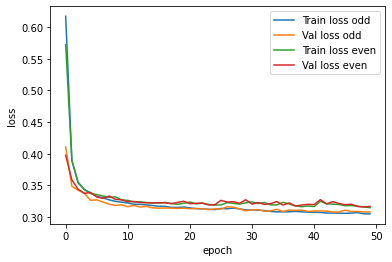

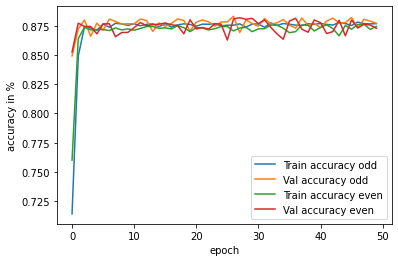

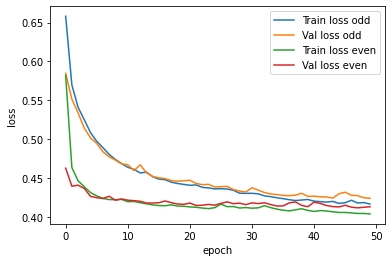

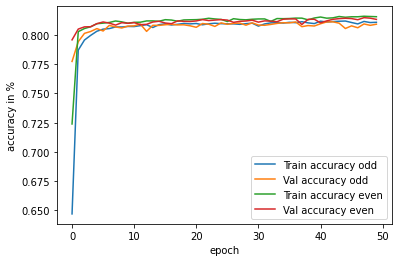

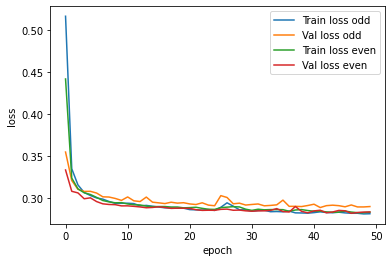

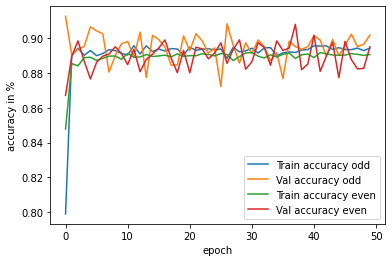

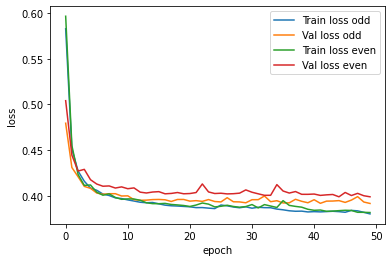

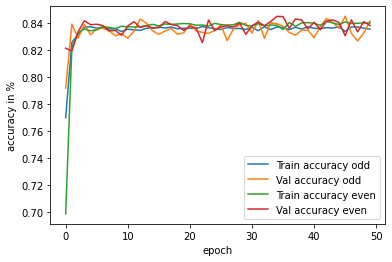

In [153]:
Plot_Metrics_KFold(history_list_cuu_pos, path_tosave)
Plot_Metrics_KFold(history_list_cuu_neg, path_tosave)
Plot_Metrics_KFold(history_list_cqu_pos, path_tosave)
Plot_Metrics_KFold(history_list_cqu_neg, path_tosave)

In [154]:
#Reload Data but without reweighting for equal Signal/Background
odd_cuu_pos, odd_cuu_neg = Split_by_Charge(odd_cuu, False)
even_cuu_pos, even_cuu_neg = Split_by_Charge(even_cuu, False)
odd_cqu_pos, odd_cqu_neg = Split_by_Charge(odd_cqu, False)
even_cqu_pos, even_cqu_neg = Split_by_Charge(even_cqu, False)

model_odd_cuu_neg = Load_Model(path_tosave, name="_odd_cuu_neg")
model_even_cuu_neg = Load_Model(path_tosave, name="_even_cuu_neg")
model_odd_cuu_pos = Load_Model(path_tosave, name="_odd_cuu_pos")
model_even_cuu_pos = Load_Model(path_tosave, name="_even_cuu_pos")
model_odd_cqu_neg = Load_Model(path_tosave, name="_odd_cqu_neg")
model_even_cqu_neg = Load_Model(path_tosave, name="_even_cqu_neg")
model_odd_cqu_pos = Load_Model(path_tosave, name="_odd_cqu_pos")
model_even_cqu_pos = Load_Model(path_tosave, name="_even_cqu_pos")

Loading model architecture and weights (/mnt/c/Users/aaron/Desktop/PhD/Same_Sign_Top/NN_for_sstt/NN/Models/V05_SvsS/architecture_odd_cuu_neg.json, /mnt/c/Users/aaron/Desktop/PhD/Same_Sign_Top/NN_for_sstt/NN/Models/V05_SvsS/weights_odd_cuu_neg.h5)
Loading model architecture and weights (/mnt/c/Users/aaron/Desktop/PhD/Same_Sign_Top/NN_for_sstt/NN/Models/V05_SvsS/architecture_even_cuu_neg.json, /mnt/c/Users/aaron/Desktop/PhD/Same_Sign_Top/NN_for_sstt/NN/Models/V05_SvsS/weights_even_cuu_neg.h5)
Loading model architecture and weights (/mnt/c/Users/aaron/Desktop/PhD/Same_Sign_Top/NN_for_sstt/NN/Models/V05_SvsS/architecture_odd_cuu_pos.json, /mnt/c/Users/aaron/Desktop/PhD/Same_Sign_Top/NN_for_sstt/NN/Models/V05_SvsS/weights_odd_cuu_pos.h5)
Loading model architecture and weights (/mnt/c/Users/aaron/Desktop/PhD/Same_Sign_Top/NN_for_sstt/NN/Models/V05_SvsS/architecture_even_cuu_pos.json, /mnt/c/Users/aaron/Desktop/PhD/Same_Sign_Top/NN_for_sstt/NN/Models/V05_SvsS/weights_even_cuu_pos.h5)
Loading 

In [155]:
pred1_cuu = model_even_cuu_pos.predict(odd_cuu_pos[0])
pred2_cuu = model_odd_cuu_pos.predict(even_cuu_pos[0])
pred3_cuu = model_even_cuu_neg.predict(odd_cuu_neg[0])
pred4_cuu = model_odd_cuu_neg.predict(even_cuu_neg[0])

truth1_cuu = odd_cuu_pos[1]
truth2_cuu = even_cuu_pos[1]
truth3_cuu = odd_cuu_neg[1]
truth4_cuu = even_cuu_neg[1]

weights1_cuu = odd_cuu_pos[2]
weights2_cuu = even_cuu_pos[2]
weights3_cuu = odd_cuu_neg[2]
weights4_cuu = even_cuu_neg[2]

pred_cuu_pos = np.concatenate([pred1_cuu, pred2_cuu])
truth_cuu_pos = np.concatenate([truth1_cuu, truth2_cuu])
weights_cuu_pos = np.concatenate([weights1_cuu, weights2_cuu])

pred_cuu_neg = np.concatenate([pred3_cuu, pred4_cuu])
truth_cuu_neg = np.concatenate([truth3_cuu, truth4_cuu])
weights_cuu_neg = np.concatenate([weights3_cuu, weights4_cuu])

pred_cuu = np.concatenate([pred1_cuu, pred2_cuu, pred3_cuu, pred4_cuu])
truth_cuu = np.concatenate([truth1_cuu, truth2_cuu, truth3_cuu, truth4_cuu])
weights_cuu = np.concatenate([weights1_cuu, weights2_cuu, weights3_cuu, weights4_cuu])

In [156]:
pred1_cqu = model_even_cqu_pos.predict(odd_cqu_pos[0])
pred2_cqu = model_odd_cqu_pos.predict(even_cqu_pos[0])
pred3_cqu = model_even_cqu_neg.predict(odd_cqu_neg[0])
pred4_cqu = model_odd_cqu_neg.predict(even_cqu_neg[0])

truth1_cqu = odd_cqu_pos[1]
truth2_cqu = even_cqu_pos[1]
truth3_cqu = odd_cqu_neg[1]
truth4_cqu = even_cqu_neg[1]

weights1_cqu = odd_cqu_pos[2]
weights2_cqu = even_cqu_pos[2]
weights3_cqu = odd_cqu_neg[2]
weights4_cqu = even_cqu_neg[2]

pred_cqu_pos = np.concatenate([pred1_cqu, pred2_cqu])
truth_cqu_pos = np.concatenate([truth1_cqu, truth2_cqu])
weights_cqu_pos = np.concatenate([weights1_cqu, weights2_cqu])

pred_cqu_neg = np.concatenate([pred3_cqu, pred4_cqu])
truth_cqu_neg = np.concatenate([truth3_cqu, truth4_cqu])
weights_cqu_neg = np.concatenate([weights3_cqu, weights4_cqu])

pred_cqu = np.concatenate([pred1_cqu, pred2_cqu, pred3_cqu, pred4_cqu])
truth_cqu = np.concatenate([truth1_cqu, truth2_cqu, truth3_cqu, truth4_cqu])
weights_cqu = np.concatenate([weights1_cqu, weights2_cqu, weights3_cqu, weights4_cqu])

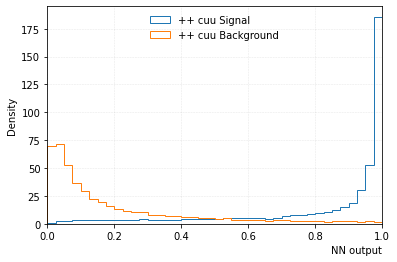

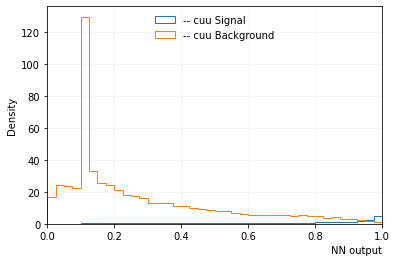

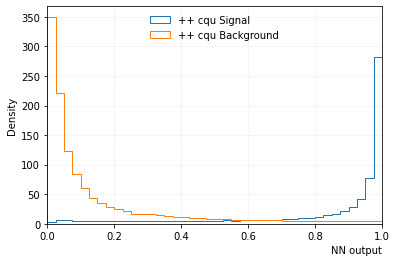

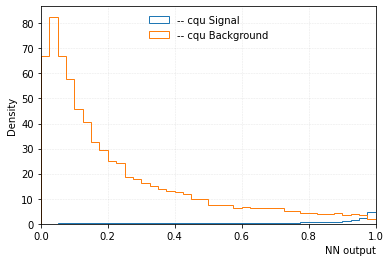

In [157]:
fig = plt.figure()
plt.grid(color='k', which='both', linestyle='--', lw=0.5, alpha=0.1, zorder = 0)
plt.xlabel("NN output", horizontalalignment='right', x=1)
plt.xlim([0,1])
plt.ylabel("Density")
#plt.yscale('log')
histargs = {"bins":40, "range":(0,1.), "histtype":'step'}
plt.hist(pred_cuu_pos[:,0][truth_cuu_pos==1],label = "++ cuu Signal", **histargs, weights=weights_cuu_pos[truth_cuu_pos==1])
plt.hist(pred_cuu_pos[:,0][truth_cuu_pos==0],label = "++ cuu Background", **histargs, weights=weights_cuu_pos[truth_cuu_pos==0])
plt.legend(loc='upper center', frameon=False)
plt.show()

fig = plt.figure()
plt.grid(color='k', which='both', linestyle='--', lw=0.5, alpha=0.1, zorder = 0)
plt.xlabel("NN output", horizontalalignment='right', x=1)
plt.xlim([0,1])
plt.ylabel("Density")
#plt.yscale('log')
histargs = {"bins":40, "range":(0,1.), "histtype":'step'}
plt.hist(pred_cuu_neg[:,0][truth_cuu_neg==1],label = "-- cuu Signal", **histargs, weights=weights_cuu_neg[truth_cuu_neg==1])
plt.hist(pred_cuu_neg[:,0][truth_cuu_neg==0],label = "-- cuu Background", **histargs, weights=weights_cuu_neg[truth_cuu_neg==0])
plt.legend(loc='upper center', frameon=False)
plt.show()

fig = plt.figure()
plt.grid(color='k', which='both', linestyle='--', lw=0.5, alpha=0.1, zorder = 0)
plt.xlabel("NN output", horizontalalignment='right', x=1)
plt.xlim([0,1])
plt.ylabel("Density")
#plt.yscale('log')
histargs = {"bins":40, "range":(0,1.), "histtype":'step'}
plt.hist(pred_cqu_pos[:,0][truth_cqu_pos==1],label = "++ cqu Signal", **histargs, weights=weights_cqu_pos[truth_cqu_pos==1])
plt.hist(pred_cqu_pos[:,0][truth_cqu_pos==0],label = "++ cqu Background", **histargs, weights=weights_cqu_pos[truth_cqu_pos==0])
plt.legend(loc='upper center', frameon=False)
plt.show()

fig = plt.figure()
plt.grid(color='k', which='both', linestyle='--', lw=0.5, alpha=0.1, zorder = 0)
plt.xlabel("NN output", horizontalalignment='right', x=1)
plt.xlim([0,1])
plt.ylabel("Density")
#plt.yscale('log')
histargs = {"bins":40, "range":(0,1.), "histtype":'step'}
plt.hist(pred_cqu_neg[:,0][truth_cqu_neg==1],label = "-- cqu Signal", **histargs, weights=weights_cqu_neg[truth_cqu_neg==1])
plt.hist(pred_cqu_neg[:,0][truth_cqu_neg==0],label = "-- cqu Background", **histargs, weights=weights_cqu_neg[truth_cqu_neg==0])
plt.legend(loc='upper center', frameon=False)
plt.show()

In [158]:
fpr1, tpr1, thr1 = roc_curve(truth_cuu_pos, pred_cuu_pos, sample_weight=weights_cuu_pos)
fpr2, tpr2, thr2 = roc_curve(truth_cuu_neg, pred_cuu_neg, sample_weight=weights_cuu_neg)
fpr3, tpr3, thr3 = roc_curve(truth_cqu_pos, pred_cqu_pos, sample_weight=weights_cqu_pos)
fpr4, tpr4, thr4 = roc_curve(truth_cqu_neg, pred_cqu_neg, sample_weight=weights_cqu_neg)

roc_auc1 = auc(fpr1, tpr1)
roc_auc2 = auc(fpr2, tpr2)
roc_auc3 = auc(fpr3, tpr3)
roc_auc4 = auc(fpr4, tpr4)

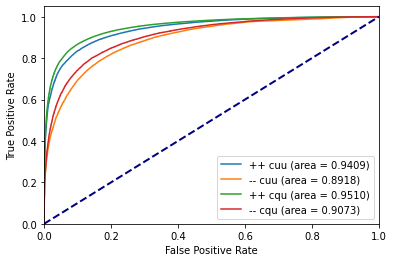

In [159]:
plt.plot(fpr1, tpr1 ,label='++ cuu (area = {:.4f})'.format(roc_auc1))
plt.plot(fpr2, tpr2 ,label='-- cuu (area = {:.4f})'.format(roc_auc2))
plt.plot(fpr3, tpr3 ,label='++ cqu (area = {:.4f})'.format(roc_auc3))
plt.plot(fpr4, tpr4 ,label='-- cqu (area = {:.4f})'.format(roc_auc4))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

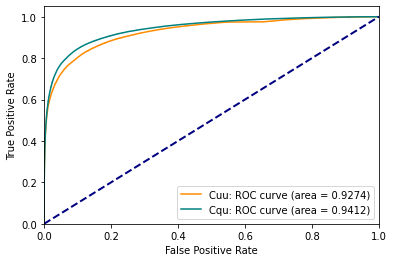

In [160]:
fpr_cuu, tpr_cuu, thr_cuu = roc_curve(truth_cuu, pred_cuu, sample_weight=weights_cuu)
fpr_cqu, tpr_cqu, thr_cqu = roc_curve(truth_cqu, pred_cqu, sample_weight=weights_cqu)

roc_auc_cuu = auc(fpr_cuu, tpr_cuu)
roc_auc_cqu = auc(fpr_cqu, tpr_cqu)

fig = plt.figure()
plt.plot(fpr_cuu, tpr_cuu, color='darkorange',label='Cuu: ROC curve (area = {:.4f})'.format(roc_auc_cuu))
plt.plot(fpr_cqu, tpr_cqu, color='teal',label='Cqu: ROC curve (area = {:.4f})'.format(roc_auc_cqu))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

# Study why Charge Split doesnt help

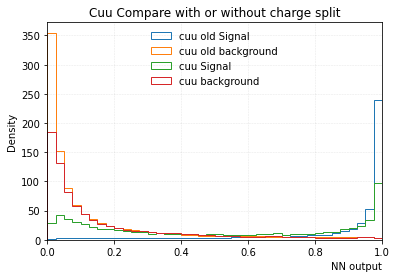

In [91]:
fig = plt.figure()
plt.title("Cuu Compare with or without charge split")
plt.grid(color='k', which='both', linestyle='--', lw=0.5, alpha=0.1, zorder = 0)
plt.xlabel("NN output", horizontalalignment='right', x=1)
plt.xlim([0,1])
plt.ylabel("Density")
#plt.yscale('log')
histargs = {"bins":40, "range":(0,1.), "histtype":'step'}
plt.hist(pred_cuu_old[:,0][truth_cuu_old==1],label = "cuu old Signal", **histargs, weights=weights_cuu_old[truth_cuu_old==1])
plt.hist(pred_cuu_old[:,0][truth_cuu_old==0],label = "cuu old background", **histargs, weights=weights_cuu_old[truth_cuu_old==0])
plt.hist(pred_cuu[:,0][truth_cuu==1],label = "cuu Signal", **histargs, weights=weights_cuu_old[truth_cuu==1])
plt.hist(pred_cuu[:,0][truth_cuu==0],label = "cuu background", **histargs, weights=weights_cuu_old[truth_cuu==0])
plt.legend(loc='upper center', frameon=False)
plt.show()

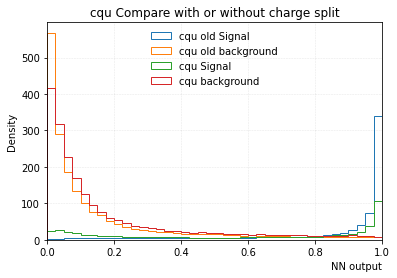

In [92]:
fig = plt.figure()
plt.title("cqu Compare with or without charge split")
plt.grid(color='k', which='both', linestyle='--', lw=0.5, alpha=0.1, zorder = 0)
plt.xlabel("NN output", horizontalalignment='right', x=1)
plt.xlim([0,1])
plt.ylabel("Density")
#plt.yscale('log')
histargs = {"bins":40, "range":(0,1.), "histtype":'step'}
plt.hist(pred_cqu_old[:,0][truth_cqu_old==1],label = "cqu old Signal", **histargs, weights=weights_cqu_old[truth_cqu_old==1])
plt.hist(pred_cqu_old[:,0][truth_cqu_old==0],label = "cqu old background", **histargs, weights=weights_cqu_old[truth_cqu_old==0])
plt.hist(pred_cqu[:,0][truth_cqu==1],label = "cqu Signal", **histargs, weights=weights_cqu_old[truth_cqu==1])
plt.hist(pred_cqu[:,0][truth_cqu==0],label = "cqu background", **histargs, weights=weights_cqu_old[truth_cqu==0])
plt.legend(loc='upper center', frameon=False)
plt.show()